In [82]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from scipy.stats import linregress, norm, spearmanr

from bqplot import (
    LogScale, LinearScale, ColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Toolbar
)
import bqplot.marks as bqm
from IPython.display import display
import ipywidgets as widgets

plt.style.use('ggplot')

pd.options.mode.chained_assignment = None  # default='warn'

In [60]:
#This uses data from AnAge, a curated database of animal specifications, part of the Human Ageing Genomic Resources

raw_data = pd.read_csv('anage_data.txt', sep="\t")
genome = pd.read_csv('genomes.txt', sep='\t', encoding='latin-1')
GO_data = pd.read_csv('animalsGO.txt', sep='\t')

#Remove species with missing data
data = raw_data[np.isfinite(raw_data['Body mass (g)'])]

#Add column for whether animal has had its genome sequenced
data['Binomial'] = data['Genus'] + ' ' + data['Species']
data = pd.merge(data, genome, how="outer", on='Binomial')
data['Genome'] = data['Genome'].fillna(value=0)

data = pd.merge(data, GO_data, how="outer", on='Common name')
data.drop(['Genus_x', 'Species_x', 'Unnamed: 0', 'Genus_y', 'Species_y'], 1)

data = data[np.isfinite(data['Maximum longevity (yrs)'])]
data = data[np.isfinite(data['Metabolic rate (W)'])]
data = data[np.isfinite(data['Temperature (K)'])]

data['Temperature (C)'] = data['Temperature (K)'] - 273.15
data['Metabolic rate/Body mass (W/g)'] = data['Metabolic rate (W)']/data['Body mass (g)']
data['Lifespan Constant'] = data['Maximum longevity (yrs)'] * data['Body mass (g)'] / data['Metabolic rate (W)']
data['Lifetime expenditure of energy (W/yrs/g)'] = data['Metabolic rate (W)']/data['Maximum longevity (yrs)']/data['Body mass (g)']

data = data.reset_index()

In [61]:
mammals_and_birds = data[(data['Class']!='Reptilia') & (data['Class']!='Amphibia')]
repts_and_amphibs = data[(data['Class']=='Reptilia') | (data['Class']=='Amphibia')]
mammals = data[data['Class'] == 'Mammalia']

birds = data[data['Class'] == 'Aves']

In [4]:
rodents = data[data['Order']=='Rodentia']
carnivores = data[data['Order']=='Carnivora']
bats = data[data['Order']=='Chiroptera']
primates = data[data['Order']=='Primates']

In [5]:
#data = data[(data['Sample size']=='large') | (data['Sample size']=='huge')]

# Lifespan vs. Body Mass

### Raw Data

Text(0.5, 1.0, 'Species Body Mass vs. Lifespan')

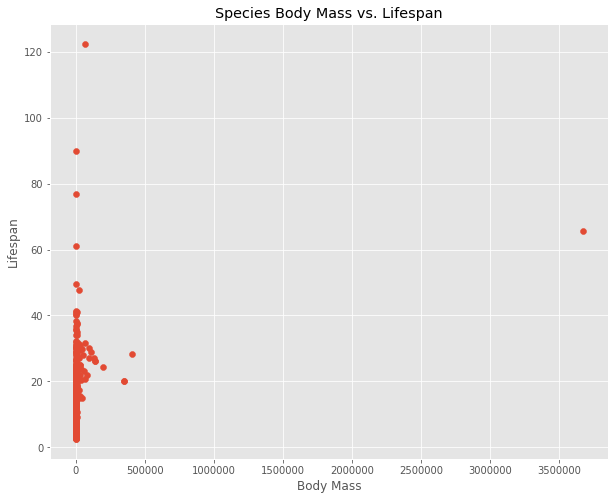

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(data['Body mass (g)'], data['Maximum longevity (yrs)'])
#plt.xlim(xmin=-2000,xmax=100000)
plt.xlabel('Body Mass')
plt.ylabel('Lifespan')
plt.title('Species Body Mass vs. Lifespan')

### Log Standardized Data

In [7]:
BM_min, BM_max = np.min(data['Body mass (g)'].apply(np.min)), np.max(data['Body mass (g)'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['Maximum longevity (yrs)'].apply(np.min)), np.max(data['Maximum longevity (yrs)'].apply(np.max))
temp_min, temp_max = np.min(data['Temperature (C)'].apply(np.min)), np.max(data['Temperature (C)'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Max Lifespan (yrs)'])

fig_scat = Scatter(x=data['Body mass (g)'], y=data['Maximum longevity (yrs)'], 
                      names=data['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Max Lifespan (yrs)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

label = widgets.Label()

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Maximum Lifespan Across Animal Species?')

box = widgets.VBox([fig])

display(box)

### Power Statistics

In [8]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Body mass (g)']), np.log(data['Maximum longevity (yrs)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and Lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and Lifespan: (0.12749269796998863, 0.1770201133353707)
The r^2 value for the relationship is 0.2956339315083229.
The associated p-value is 3.6552275643209693e-28.


### Effect of Temperature on Lifespan for Similarly Sized Species

In [9]:
temp_data = data[(data['Body mass (g)'] >= 20) & (data['Body mass (g)'] <= 30)]
temp_data['1/Temperature'] = 1/temp_data['Temperature (C)']

lifespan_min, lifespan_max = np.min(temp_data['Maximum longevity (yrs)'].apply(np.min)), np.max(temp_data['Maximum longevity (yrs)'].apply(np.max))
temp_min, temp_max = np.min(temp_data['1/Temperature'].apply(np.min)), np.max(temp_data['1/Temperature'].apply(np.max))

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', '1/Temperature (1/C)', 'Max Lifespan (yrs)'])

fig_scat = Scatter(x=temp_data['1/Temperature'], y=temp_data['Maximum longevity (yrs)'],
                      names=temp_data['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='1/Temperature (1/C)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Max Lifespan (yrs)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does an Inverse Relationship Exist Between Temp. and Lifespan?')

fig

Figure(axes=[Axis(label='1/Temperature (1/C)', scale=LinearScale(max=0.06734006734006724, min=0.02439024390243…

# Association Between Body Mass and BMR

#### Note: the asiatic elephant is an influential point

### Raw Data

Text(0.5, 1.0, 'Species Metabolic Rate vs. Body Mass')

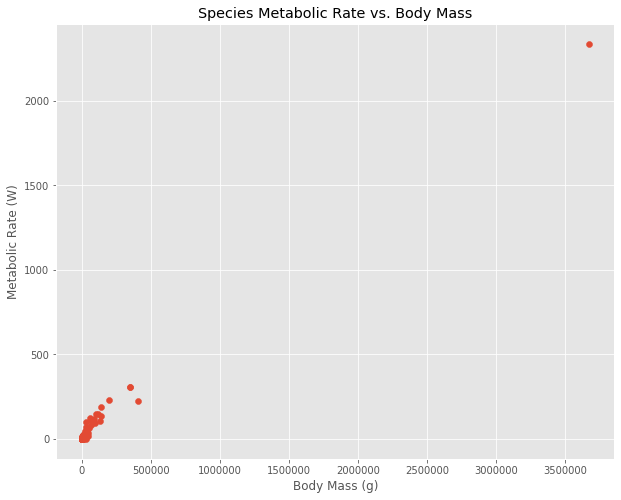

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(data['Body mass (g)'], data['Metabolic rate (W)'])
#plt.xlim(xmin=-10000,xmax=500000)
#plt.ylim(ymin=-10,ymax=400)
plt.xlabel('Body Mass (g)')
plt.ylabel('Metabolic Rate (W)')
plt.title('Species Metabolic Rate vs. Body Mass')

In [53]:
x_min, x_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].apply(np.max))
y_min, y_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].apply(np.max))
size_min, size_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Stress']/mammals_and_birds[mammals_and_birds['Genome']==1]['Total'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Stress']/mammals_and_birds[mammals_and_birds['Genome']==1]['Total'].apply(np.max))

x_sc = LogScale(min=x_min, max=x_max)
y_sc = LogScale(min=y_min, max=y_max)
size_sc = LinearScale(min=size_min, max=size_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', 'BMR / M', 'Lifespan', '% Stress'])

fig_scat = Scatter(x=mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].round(decimals = 3), 
                   y=mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].round(decimals=1), size=mammals_and_birds[mammals_and_birds['Genome']==1]['Stress']/mammals_and_birds[mammals_and_birds['Genome']==1]['Total'],
                      names=mammals_and_birds[mammals_and_birds['Genome']==1]['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=500, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='BMR / M', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Lifespan', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='Lifespan Compared to BMR / M (Size = % of Stress Genes)')
fig.layout.height = '650px'
fig.layout.width = '1000px'

display(fig)


Figure(axes=[Axis(label='BMR / M', scale=LogScale(max=0.041428571428571426, min=0.0007140625)), Axis(label='Li…

In [57]:
alpha, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Metabolic rate (W)']/mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Maximum longevity (yrs)']))
low_bound = alpha - 1.96 * std_err
high_bound = alpha + 1.96 * std_err

print('95% CI for power relationship between BMR/M and lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BMR/M and lifespan: (-0.6171163643645914, -0.4598420462050025)
The r^2 value for the relationship is 0.3630746018426739.
The associated p-value is 8.229714545707137e-33.


In [93]:
genned_data = mammals_and_birds[mammals_and_birds['Genome']==1]
genned_data = genned_data[np.isfinite(genned_data['Total'])]

In [110]:
y_min, y_max = np.min(genned_data['NL'].apply(np.min)), np.max(genned_data['NL'].apply(np.max))
x_min, x_max = np.min(genned_data['DNA_Repair']/genned_data['Total'].apply(np.min)), np.max(genned_data['DNA_Repair']/genned_data['Total'].apply(np.max))

x_sc = LinearScale(min=x_min, max=x_max)
y_sc = LinearScale(min=y_min, max=y_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', '% Uncoupling', 'Normalized Lifespan'])

fig_scat = Scatter(x=genned_data['DNA_Repair']/genned_data['Total'].round(decimals = 3), 
                   y=genned_data['NL'].round(decimals=1), 
                      names=genned_data['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=50, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Proportion of DNA Repair Genes', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Normalized Lifespan', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='Normalized Lifespan Compared to Proportion of DNA Repair Genes')
fig.layout.height = '650px'
fig.layout.width = '1000px'

display(fig)


Figure(axes=[Axis(label='Proportion of DNA Repair Genes', scale=LinearScale(max=0.014683153013910355, min=0.00…

In [109]:
coef, p = spearmanr(genned_data['NL'], genned_data['Oxidant_Detox']/genned_data['Total'])
print('Spearmans correlation coefficient: %.3f' % coef)

alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.054
Samples are uncorrelated (fail to reject H0) p=0.742


In [106]:
data['Stress'].median()

1106.0

### Log Standardized Data

In [13]:
BM_min, BM_max = np.min(data['Body mass (g)'].apply(np.min)), np.max(data['Body mass (g)'].apply(np.max))
BMR_min, BMR_max = np.min(data['Metabolic rate (W)'].apply(np.min)), np.max(data['Metabolic rate (W)'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['Maximum longevity (yrs)'].apply(np.min)), np.max(data['Maximum longevity (yrs)'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Metabolic Rate (W)'])

fig_scat1 = Scatter(x=mammals_and_birds['Body mass (g)'], y=mammals_and_birds['Metabolic rate (W)'].round(decimals = 3), colors=['blue'],
                      names=mammals_and_birds['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

fig_scat2 = Scatter(x=repts_and_amphibs['Body mass (g)'], y=repts_and_amphibs['Metabolic rate (W)'].round(decimals = 3), colors=['orange'],
                      names=repts_and_amphibs['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Metabolic Rate (W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

fig = Figure(marks=[fig_scat1, fig_scat2], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Metabolic Rate Across Animal Species?')

fig

Figure(axes=[Axis(label='Body Mass (g)', scale=LogScale(max=3672000.0, min=0.76)), Axis(label='Metabolic Rate …

### Log Standardized Data with LoBF

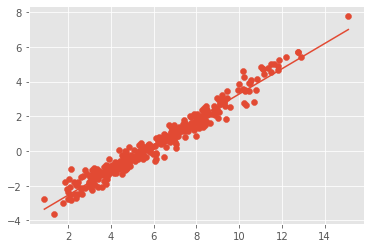

In [14]:
plt.scatter(np.log(mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Metabolic rate (W)']))
y = np.log(mammals_and_birds['Metabolic rate (W)'])
x = np.log(mammals_and_birds['Body mass (g)'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

### Power Statistics for All Included Species

In [15]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Body mass (g)']), np.log(data['Metabolic rate (W)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and BMR: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and BMR: (0.7628727128898212, 0.8383388345136489)
The r^2 value for the relationship is 0.8332883654177254.
The associated p-value is 1.1790809373508604e-136.


### Power Statistics for Mammals and Birds

In [16]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Metabolic rate (W)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and BMR for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and BMR for mammals and birds: (0.7109383969918326, 0.7435894040453734)
The r^2 value for the relationship is 0.9601997643563315.
The associated p-value is 2.769792286601012e-223.


#### Binned Data to Account for Mass Skew

In [17]:
bins = np.arange(np.log(mammals_and_birds['Body mass (g)']).min(), np.log(mammals_and_birds['Body mass (g)']).max(), .25)
groupsMB = mammals_and_birds.groupby(np.digitize(np.log(mammals_and_birds['Body mass (g)']), bins))


In [18]:
slope1, intercept1, r_value, p_value, std_err1 = linregress(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()))
low_bound = slope1 - 1.96 * std_err1
high_bound = slope1 + 1.96 * std_err1

print('95% CI for power relationship between BM and max lifespan for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and max lifespan for mammals and birds: (0.723380272658164, 0.7676069208131375)
The r^2 value for the relationship is 0.9900228618986997.
The associated p-value is 1.142773830033781e-45.


### Power Statistics for Reptiles and Amphibians

In [19]:
slope2, intercept2, r_value, p_value, std_err2 = linregress(np.log(repts_and_amphibs['Body mass (g)']), np.log(repts_and_amphibs['Metabolic rate (W)']))
low_bound = slope2 - 1.96 * std_err2
high_bound = slope2 + 1.96 * std_err2

print('95% CI for power relationship between BM and max lifespan for reptiles and amphibians: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and max lifespan for reptiles and amphibians: (0.7056139986949743, 0.9063785443677932)
The r^2 value for the relationship is 0.8984273387712045.
The associated p-value is 1.954320467127725e-15.


### Significance Test in Difference in Power for Mammals and Birds versus Reptiles and Amphibians
Significant at the 0.10 significance level but not at 0.05.

In [20]:
numerator = slope1 - slope2
denominator = pow((pow(std_err1, 2) + pow(std_err2, 2)), 1/2)
z = numerator / denominator 
norm.sf(abs(z))

0.12431667145873648

# Testing Existence of Constants in Lifetime Energy Expenditure

### Association Between Metabolic Expenditure and Lifespan

In [21]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), np.log(groupsMB['Maximum longevity (yrs)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.3868144531835799, -0.27766764032935065)
The r^2 value for the relationship is 0.7639263240985831.
The associated p-value is 2.1897503862360757e-15.


Text(0.5, 1.0, 'Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

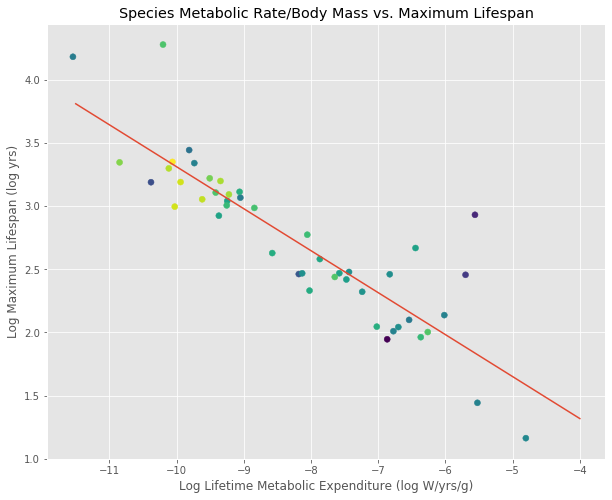

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), np.log(groupsMB['Maximum longevity (yrs)'].mean()), c=groupsMB['Temperature (C)'].mean())
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(-11.5, -4)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.ylabel('Log Maximum Lifespan (log yrs)')
plt.title('Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

Text(0.5, 1.0, 'Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

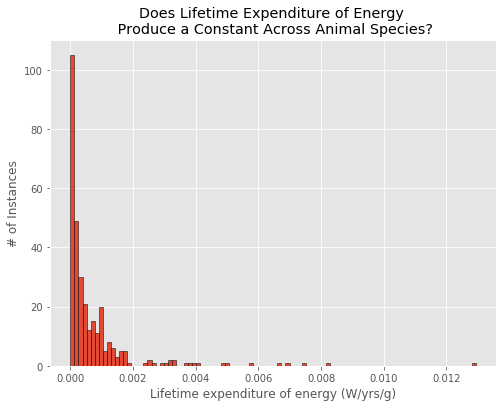

In [23]:
#temp_data = mammals_and_birds[mammals_and_birds['Lifespan Constant'] < 100000]
# Several outliers (11) exist past the 100,000 mark

plt.figure(figsize=(8,6))
plt.hist(mammals_and_birds['Lifetime expenditure of energy (W/yrs/g)'], bins=100, ec="k")
plt.xlabel('Lifetime expenditure of energy (W/yrs/g)')
plt.ylabel('# of Instances')
plt.title('Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

### Association Between Body Mass and Metabolic Expenditure

In [24]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.47237798896342875, -0.40850553140383994)
The r^2 value for the relationship is 0.9432016933779253.
The associated p-value is 4.844576557828314e-29.


Text(0.5, 1.0, 'Species Body Mass vs. Lifetime Energy Expenditure')

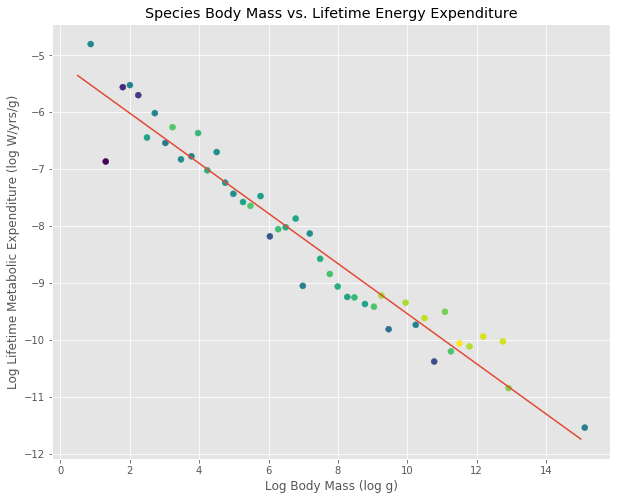

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), c=groupsMB['Temperature (C)'].mean())
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(0.5, 15)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Body Mass (log g)')
plt.ylabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.title('Species Body Mass vs. Lifetime Energy Expenditure')

# Temperature vs. Metabolic Rate

In [26]:
#The Asiatic elephant is an extreme outlier in terms of metabolic rate (about 2300 W)
mammals_and_birds = mammals_and_birds[mammals_and_birds['Metabolic rate (W)'] < 2000]

#The Eastern red-backed salamander is an outlier in terms of body temperature (about 5.35 C)
data = data[data['Temperature (C)'] > 10]

Text(0.5, 1.0, 'Species Internal Body Temperature vs. Metabolic Rate')

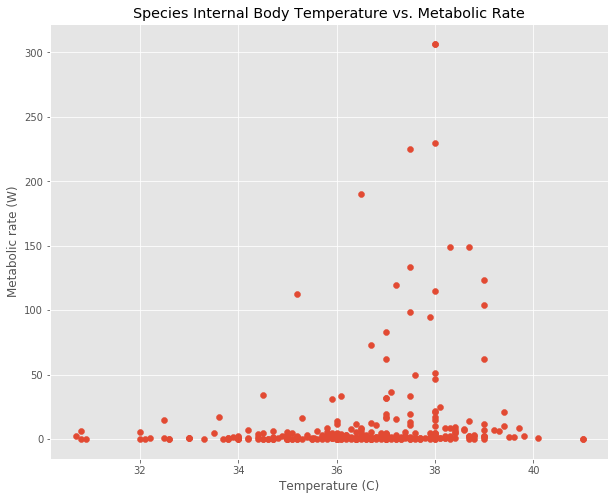

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(mammals_and_birds['Temperature (C)'], mammals_and_birds['Metabolic rate (W)'])
plt.xlabel('Temperature (C)')
plt.ylabel('Metabolic rate (W)')

plt.title('Species Internal Body Temperature vs. Metabolic Rate')

Text(0.5, 1.0, 'Distribution of Metabolic Rates \n Among Mammals and Birds')

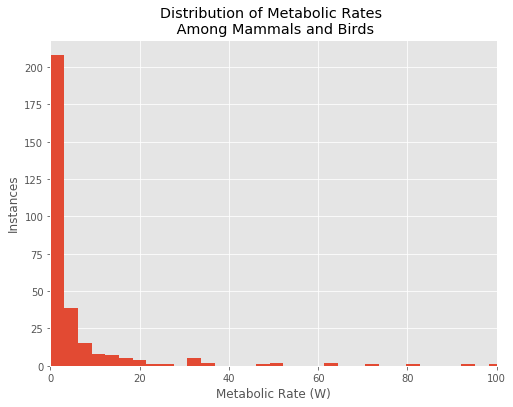

In [28]:
plt.figure(figsize = (8, 6))
plt.hist(mammals_and_birds['Metabolic rate (W)'], bins=100)
plt.xlim(xmin=0,xmax=100)
plt.xlabel('Metabolic Rate (W)')
plt.ylabel('Instances')
plt.title('Distribution of Metabolic Rates \n Among Mammals and Birds')

In [29]:
temp_min, temp_max = np.min(1/primates['Temperature (C)'].apply(np.min)), np.max(1/primates['Temperature (C)'].apply(np.max))
BMR_min, BMR_max = np.min(primates['Metabolic rate (W)'].apply(np.min)), np.max(primates['Metabolic rate (W)'].apply(np.max))

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', '1/Temperature (1/C)', 'Log Metabolic Rate (log W)'])

fig_scat = Scatter(x=1/primates['Temperature (C)'], y=primates['Metabolic rate (W)'],
                      names=primates['Common name'], display_names=True,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='1/Temperature (1/C)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Log Metabolic Rate (log W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Arrhenius Relationship of Temperature vs. Metabolic Rate in Primates')

fig

Figure(axes=[Axis(label='1/Temperature (1/C)', scale=LinearScale(max=0.02958579881656804, min=0.02544529262086…

In [30]:
temp_min, temp_max = np.min(1/groupsMB['Temperature (C)'].min()), np.max(1/groupsMB['Temperature (C)'].max())
BMR_min, BMR_max = np.min(groupsMB['Metabolic rate (W)'].min()), np.max(groupsMB['Metabolic rate (W)'].max())

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['x', 'y'], 
             labels=['1/Temperature (1/C)', 'Log Metabolic Rate (log W)'])

fig_scat = Scatter(x=1/groupsMB['Temperature (C)'].mean(), y=groupsMB['Metabolic rate (W)'].mean().round(decimals=2),
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='1/Temperature (1/C)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Log Metabolic Rate (log W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Arrhenius Relationship of Temperature vs. Metabolic Rate in Mammals and Birds (Binned)')

fig

Figure(axes=[Axis(label='1/Temperature (1/C)', scale=LinearScale(max=0.029411764705882353, min=0.0263157894736…

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(1/groupsMB['Temperature (C)'].mean(), np.log(groupsMB['Metabolic rate (W)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')


95% CI for slope: (-3069.9776284078416, -1271.5609302013127)
The r^2 value for the relationship is 0.33723142971877534.
The associated p-value is 2.3269325462473907e-05.


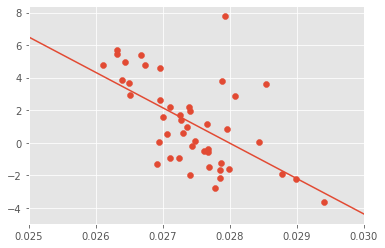

In [32]:
plt.scatter(x=1/groupsMB['Temperature (C)'].mean(), y=np.log(groupsMB['Metabolic rate (W)'].mean()))
plt.xlim(xmin=0.025, xmax=0.030)

xlin = np.linspace(0.025, 0.030, 20)
ylin = slope * xlin + intercept
plt.plot(xlin, ylin)

### Metabolic Rate vs. Lifespan

In [33]:
BM_min, BM_max = np.min(mammals_and_birds['Body mass (g)'].apply(np.min)), np.max(mammals_and_birds['Body mass (g)'].apply(np.max))
BMR_min, BMR_max = np.min(mammals_and_birds['Metabolic rate (W)'].apply(np.min)), np.max(mammals_and_birds['Metabolic rate (W)'].apply(np.max))
lifespan_min, lifespan_max = np.min(mammals_and_birds['Maximum longevity (yrs)'].apply(np.min)), np.max(mammals_and_birds['Maximum longevity (yrs)'].apply(np.max))

x_sc = LinearScale(min=BMR_min, max=BMR_max)
y_sc = LinearScale(min=lifespan_min, max=lifespan_max)
size_sc = LinearScale(min=BM_min, max=BM_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', 'Metabolic rate (W)', 'Maximum lifespan (years)', 'Body mass (g)'])

fig_scat = Scatter(x=mammals_and_birds['Metabolic rate (W)'].round(decimals = 3), y=mammals_and_birds['Maximum longevity (yrs)'], size=mammals_and_birds['Body mass (g)'],
                      names=mammals_and_birds['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=800, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Metabolic Rate (W)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Maximum Lifespan (years)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='How Does Metabolic Rate Correlate with Maximum Lifespan \n in Mammals and Birds?')
fig.layout.height = '600px'
fig.layout.width = '800px'

fig

Figure(axes=[Axis(label='Metabolic Rate (W)', scale=LinearScale(max=306.77, min=0.027000000000000003)), Axis(l…

In [34]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Metabolic rate (W)']), np.log(mammals_and_birds['Maximum longevity (yrs)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (0.18619675866030905, 0.2542568259403909)
The r^2 value for the relationship is 0.3380816294288775.
The associated p-value is 4.591825387119355e-30.


Text(0, 0.5, 'Maximum Lifespan (yrs)')

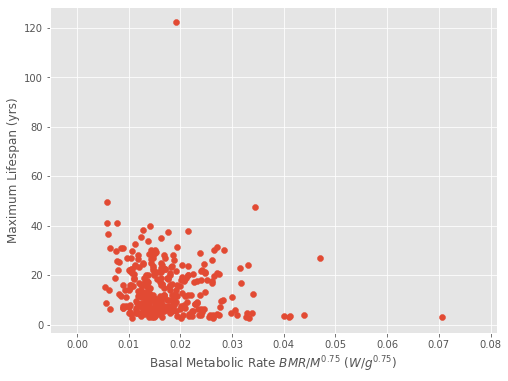

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(mammals_and_birds['Metabolic rate (W)']/np.power(mammals_and_birds['Body mass (g)'], .75), mammals_and_birds['Maximum longevity (yrs)'])
plt.xlabel('Basal Metabolic Rate $BMR/M^{0.75}$ ($W/g^{0.75}$)')
plt.ylabel('Maximum Lifespan (yrs)')



Text(0, 0.5, 'Maximum Lifespan (yrs)')

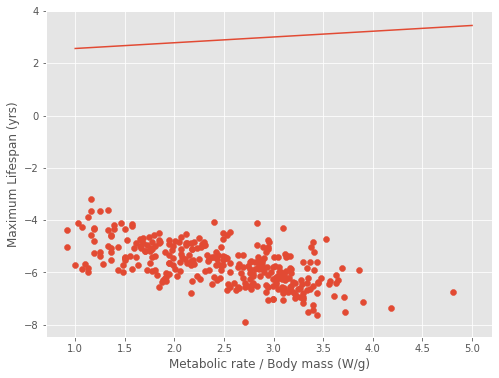

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(np.log(mammals['Maximum longevity (yrs)']), np.log(mammals['Metabolic rate (W)']/mammals['Body mass (g)']))

xlin = np.linspace(1, 5, 10)
ylin = slope * xlin + intercept
plt.plot(xlin, ylin)

plt.xlabel('Metabolic rate / Body mass (W/g)')
plt.ylabel('Maximum Lifespan (yrs)')


In [37]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Maximum longevity (yrs)']), np.log(mammals_and_birds['Metabolic rate (W)']/mammals_and_birds['Body mass (g)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')


95% CI for slope: (-0.7681844429265544, -0.5693589707045953)
The r^2 value for the relationship is 0.35563540370033814.
The associated p-value is 6.497222279835447e-32.


Text(0, 0.5, 'Maximum Lifespan (yrs)')

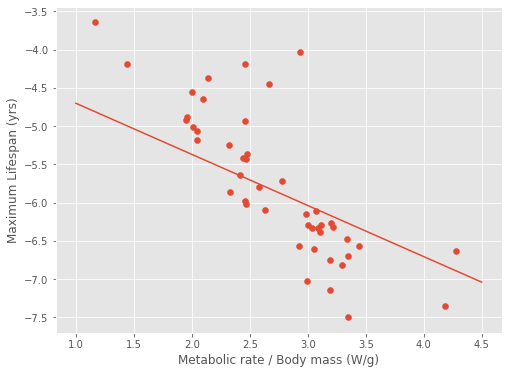

In [38]:
plt.figure(figsize=(8,6))
plt.scatter(np.log(groupsMB['Maximum longevity (yrs)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()/groupsMB['Body mass (g)'].mean()))

xlin = np.linspace(1, 4.5, 10)
ylin = slope * xlin + intercept
plt.plot(xlin, ylin)

plt.xlabel('Metabolic rate / Body mass (W/g)')
plt.ylabel('Maximum Lifespan (yrs)')


In [39]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Maximum longevity (yrs)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()/groupsMB['Body mass (g)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')


95% CI for slope: (-1.5157136793702954, -0.9860415347026216)
The r^2 value for the relationship is 0.6607590375417849.
The associated p-value is 6.826252521963855e-12.


# Lifespan / MRPM^-alpha vs. Temperature

In [62]:
data['NL'] = data['Maximum longevity (yrs)'] / (data['Metabolic rate (W)']/data['Body mass (g)']) ** (-alpha)
mammals_and_birds = data[(data['Class']!='Reptilia') & (data['Class']!='Amphibia')]

In [43]:
temp_min, temp_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Temperature (C)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Temperature (C)'].apply(np.max))
BMR_min, BMR_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['R(x)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['R(x)'].apply(np.max))
genome_no, genome_yes = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Genome'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Genome'].apply(np.max))

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LinearScale(min=BMR_min, max=BMR_max)
color_sc = ColorScale(min=genome_no, max=genome_yes, scheme='GnBu')

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', 'Body Temperature', 'Normalized Lifespan', 'Lifespan'])

fig_scat = Scatter(x=mammals_and_birds[mammals_and_birds['Genome']==1]['Temperature (C)'].round(decimals = 3), y=mammals_and_birds[mammals_and_birds['Genome']==1]['R(x)'].round(decimals=1), color=mammals_and_birds[mammals_and_birds['Genome']==1]['Genome'],
                      names=mammals_and_birds[mammals_and_birds['Genome']==1]['Common name'], display_names=True,
                      scales={'x': x_sc, 'y': y_sc, 'color': color_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Body Temperature (C)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Normalized Lifespan (yrs * (W/g)^α)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='Normalized Lifespan Compared to Internal Body Temperature Across Mammals')
fig.layout.height = '650px'
fig.layout.width = '1000px'

display(fig)


Figure(axes=[Axis(label='Body Temperature (C)', scale=LinearScale(max=41.0, min=32.0)), Axis(label='Normalized…